In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# 1. 데이터 로드
file_path = "/content/kbo_hitters_retired_enc.csv"  # Colab 기준 경로
df = pd.read_csv(file_path)

# 2. 불필요한 열 제거 및 전처리
df.drop(columns=['name', 'pic_url', 'team'], inplace=True, errors='ignore')
df.replace('-', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# 3. 은퇴 연도 라벨 생성
df['retire_year'] = df.groupby('birth')['season'].transform('max')

# 4. 시계열 구조 생성 (선수별 시즌 순서대로 시퀀스화)
feature_cols = [col for col in df.columns if col not in ['birth', 'season', 'retire_year']]
grouped = df.groupby('birth')

X_seqs = []
y_labels = []

for _, group in grouped:
    group = group.sort_values('season')
    X_seq = group[feature_cols].values
    y_val = group['retire_year'].iloc[0]
    X_seqs.append(X_seq)
    y_labels.append(y_val)

# 5. 패딩
X_padded = pad_sequences(X_seqs, dtype='float32', padding='post', value=-1.0)

# 6. X 정규화 (StandardScaler)
num_features = X_padded.shape[2]
X_reshaped = X_padded.reshape(-1, num_features)
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X_padded.shape)

# 7. y 정규화 (MinMaxScaler)
y = np.array(y_labels).reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

# 8. train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 9. 모델 정의
model = Sequential([
    Masking(mask_value=-1.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 10. 모델 학습
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2,
          epochs=100, batch_size=16, callbacks=[early_stop], verbose=1)

# 11. 예측 및 평가
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_real = y_scaler.inverse_transform(y_test)

# 12. 평가 지표 출력
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))

print(f"\n🎯 딥러닝 은퇴 연도 예측 결과")
print(f"✅ MAE  : {mae:.2f}년")
print(f"✅ RMSE : {rmse:.2f}년")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 397ms/step - loss: 0.8552 - mae: 0.8631 - val_loss: 0.1994 - val_mae: 0.3858
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.1771 - mae: 0.3865 - val_loss: 0.0900 - val_mae: 0.2454
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.1396 - mae: 0.2633 - val_loss: 0.1256 - val_mae: 0.2643
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.1780 - mae: 0.3085 - val_loss: 0.0760 - val_mae: 0.2381
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.1129 - mae: 0.2758 - val_loss: 0.0754 - val_mae: 0.2404
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - loss: 0.1145 - mae: 0.3078 - val_loss: 0.0871 - val_mae: 0.2519
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - loss: 0.1168 - mae: 0.3170 - val_loss: 0.0728 - val_mae: 0.2381
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.1002 - mae: 0.2749 - val_loss: 0.0756 - val_mae: 0.2381
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.109

In [ ]:
# ✅ Colab이나 로컬에서 TensorFlow 설치 (한 번만 실행하면 됨)
!pip install tensorflow

# ✅ 모듈 import
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 1. 데이터 로드
file_path = "/content/kbo_hitters_retired_enc.csv"  # Colab 기준
df = pd.read_csv(file_path)

# ✅ 2. 전처리
df.drop(columns=['name', 'pic_url', 'team'], inplace=True, errors='ignore')
df.replace('-', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# ✅ 3. 은퇴 나이 = retire_year - birth
df['retire_year'] = df.groupby('birth')['season'].transform('max')
df['retire_age'] = df['retire_year'] - df['birth']

# ✅ 4. 시계열 구성
feature_cols = [col for col in df.columns if col not in ['birth', 'season', 'retire_year', 'retire_age']]
X_seqs, y_labels = [], []

for _, g in df.groupby('birth'):
    g = g.sort_values('season')
    X_seqs.append(g[feature_cols].values)
    y_labels.append(g['retire_age'].iloc[0])

# ✅ 5. 시퀀스 패딩
X_padded = pad_sequences(X_seqs, dtype='float32', padding='post', value=-1.0)

# ✅ 6. X 정규화
num_features = X_padded.shape[2]
X_reshaped = X_padded.reshape(-1, num_features)
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X_reshaped).reshape(X_padded.shape)

# ✅ 7. y 정규화
y = np.array(y_labels).reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

# ✅ 8. train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# ✅ 9. LSTM 모델 구성
model = Sequential([
    Masking(mask_value=-1.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# ✅ 10. 학습
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stop], verbose=1)

# ✅ 11. 예측 + 평가
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_real = y_scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))

print("\n🎯 예측된 은퇴 나이 회귀 성능:")
print(f"✅ MAE  : {mae:.2f}세")
print(f"✅ RMSE : {rmse:.2f}세")

# ✅ 12. 예측된 은퇴 연도도 확인하고 싶다면?
# 예: birth_years = [1980, 1985, 1990, ...]
# retire_year_pred = birth_years + predicted_retire_age


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - loss: 0.3816 - mae: 0.5617 - val_loss: 0.0978 - val_mae: 0.2544
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 0.0731 - mae: 0.2064 - val_loss: 0.1364 - val_mae: 0.2331
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step - loss: 0.0743 - mae: 0.1849 - val_loss: 0.1031 - val_mae: 0.2113
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step - loss: 0.0641 - mae: 0.1771 - val_loss: 0.1017 - val_mae: 0.2751
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step - loss: 0.0766 - mae: 0.2331 - val_loss: 0.1091 - val_mae: 0.2990
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 0.0709 - mae: 0.2366 - val_loss: 0.0979 - val_mae: 0.2549
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.0626 - mae: 0.1992 - val_loss: 0.0982 - val_mae: 0.2212
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0552 - mae: 0.1662 - val_loss: 0.1018 - val_mae: 0.2131
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.0678 - mae: 0.1

In [ ]:
# 모듈 import
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# 1. 데이터 로드
file_path = "/content/kbo_hitters_retired_enc.csv"  # 코랩 기준
df = pd.read_csv(file_path)

# 2. 전처리
df.drop(columns=['name', 'pic_url', 'team'], inplace=True, errors='ignore')
df.replace('-', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# 3. 라벨 생성: 은퇴 나이
df['retire_year'] = df.groupby('birth')['season'].transform('max')
df['retire_age'] = df['retire_year'] - df['birth']

# 4. birth를 모든 시즌의 feature로 넣기 (중요!)
df['birth_feature'] = df['birth']

# 5. 시계열 데이터 만들기
feature_cols = [col for col in df.columns if col not in ['birth', 'season', 'retire_year', 'retire_age']]
X_seqs, y_labels = [], []

for _, g in df.groupby('birth'):
    g = g.sort_values('season')
    X_seq = g[feature_cols].values
    y_val = g['retire_age'].iloc[0]
    X_seqs.append(X_seq)
    y_labels.append(y_val)

# 6. 패딩
X_padded = pad_sequences(X_seqs, dtype='float32', padding='post', value=-1.0)

# 7. X 정규화
num_features = X_padded.shape[2]
X_reshaped = X_padded.reshape(-1, num_features)
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X_reshaped).reshape(X_padded.shape)

# 8. y 정규화
y = np.array(y_labels).reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

# 9. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 10. 모델 정의
model = Sequential([
    Masking(mask_value=-1.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 11. 학습
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stop], verbose=1)

# 12. 예측 및 평가
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_real = y_scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))

print(f"\n🎯 최종 은퇴 나이 예측 결과 (시계열 + birth 포함)")
print(f"✅ MAE  : {mae:.2f}세")
print(f"✅ RMSE : {rmse:.2f}세")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.3313 - mae: 0.5197 - val_loss: 0.1030 - val_mae: 0.2802
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0648 - mae: 0.1949 - val_loss: 0.1433 - val_mae: 0.2397
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.0947 - mae: 0.2229 - val_loss: 0.1045 - val_mae: 0.2098
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.0789 - mae: 0.2000 - val_loss: 0.1070 - val_mae: 0.2932
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0771 - mae: 0.2441 - val_loss: 0.1081 - val_mae: 0.2964
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 0.0744 - mae: 0.2397 - val_loss: 0.0968 - val_mae: 0.2470
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0594 - mae: 0.1859 - val_loss: 0.0970 - val_mae: 0.2278
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.0689 - mae: 0.1934 - val_loss: 0.0978 - val_mae: 0.2227
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.0599 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# 1. 데이터 로드
df = pd.read_csv("kbo_hitters_retired_enc.csv")
df.drop(columns=['name', 'pic_url', 'team'], inplace=True, errors='ignore')
df.replace('-', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# 2. 은퇴 나이 라벨 생성
df['retire_year'] = df.groupby('birth')['season'].transform('max')
df['retire_age'] = df['retire_year'] - df['birth']

# 3. 실험용 결과 저장 리스트
results = []

# 4. 윈도우 크기 3~10년까지 반복
for N in range(3, 15):
    features = []
    targets = []

    for _, group in df.groupby('birth'):
        group = group.sort_values('season')
        if len(group) < N:
            continue
        recent = group.tail(N)

        row = {}
        for col in ['PA', 'AVG', 'G', 'HR', 'H']:
            values = recent[col].values
            row[f'{col}_mean'] = np.mean(values)
            if len(values) >= 2 and values[0] != 0:
                row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0])
            else:
                row[f'{col}_trend'] = 0.0

        row['birth'] = group['birth'].iloc[0]
        row['last_season'] = group['season'].max()

        features.append(row)
        targets.append(group['retire_age'].iloc[0])

    if not features:
        continue

    X = pd.DataFrame(features)
    y = np.array(targets)

    # 정규화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 모델 학습
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({'윈도우': N, 'MAE': round(mae, 2), 'RMSE': round(rmse, 2), 'R²': round(r2, 4)})

# 5. 결과 출력
result_df = pd.DataFrame(results)
print(result_df)


    윈도우   MAE  RMSE      R²
0     3  1.48  1.78  0.9132
1     4  1.41  1.65  0.9353
2     5  1.38  1.69  0.9281
3     6  1.83  2.51  0.8412
4     7  1.65  2.03  0.9188
5     8  1.60  2.07  0.9155
6     9  1.19  1.36  0.9637
7    10  1.54  1.79  0.9369
8    11  1.38  1.64  0.9471
9    12  1.46  1.70  0.9436
10   13  1.65  2.05  0.8791
11   14  1.68  1.89  0.8974


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# 1. 데이터 로드 및 전처리
df = pd.read_csv("kbo_hitters_retired_enc.csv")
df.drop(columns=['name', 'pic_url', 'team'], inplace=True, errors='ignore')
df.replace('-', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# 2. 은퇴 나이 생성
df['retire_year'] = df.groupby('birth')['season'].transform('max')
df['retire_age'] = df['retire_year'] - df['birth']

# 3. 최근 9년 기준 feature 생성
features = []
targets = []

for _, group in df.groupby('birth'):
    group = group.sort_values('season')
    if len(group) < 9:
        continue
    recent = group.tail(9)

    row = {}
    for col in ['PA', 'AVG', 'G', 'HR', 'H']:
        values = recent[col].values
        row[f'{col}_mean'] = np.mean(values)
        if values[0] != 0:
            row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0])
        else:
            row[f'{col}_trend'] = 0.0

    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()

    features.append(row)
    targets.append(group['retire_age'].iloc[0])

X = pd.DataFrame(features)
y = np.array(targets)

# 4. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 6. XGBoost 모델 학습
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# 7. 예측 및 평가
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 8. 결과 출력
print("\n🎯 최근 9시즌 XGBoost 은퇴 나이 예측 결과")
print(f"✅ MAE  : {mae:.2f}세")
print(f"✅ RMSE : {rmse:.2f}세")
print(f"✅ R²   : {r2:.4f}")



🎯 최근 9시즌 XGBoost 은퇴 나이 예측 결과
✅ MAE  : 1.19세
✅ RMSE : 1.36세
✅ R²   : 0.9637


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# 1. 현역 데이터 로드 (시즌별 형태)
active_df = pd.read_csv("kbo_hitters_active_enc.csv")
active_df.replace('-', np.nan, inplace=True)
active_df = active_df.apply(pd.to_numeric, errors='ignore')
active_df.dropna(inplace=True)

# 2. 사용할 feature 컬럼
features_used = ['PA', 'AVG', 'G', 'HR', 'H']

# 3. 선수별 최근 9시즌 평균/변화율 만들기
predict_data = []
names = []
births = []

for name, group in active_df.groupby('name'):
    group = group.sort_values('season')
    if len(group) < 9:
        continue
    recent = group.tail(9)

    row = {}
    for col in features_used:
        values = recent[col].astype(float).values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if values[0] != 0 else 0.0

    row['birth'] = recent['birth'].iloc[0]
    row['last_season'] = recent['season'].max()

    predict_data.append(row)
    names.append(name)
    births.append(row['birth'])

X_active = pd.DataFrame(predict_data)

# 4. 은퇴자 기반 모델 훈련
retired_df = pd.read_csv("kbo_hitters_retired_enc.csv")
retired_df.drop(columns=['name', 'pic_url', 'team'], inplace=True, errors='ignore')
retired_df.replace('-', np.nan, inplace=True)
retired_df = retired_df.apply(pd.to_numeric, errors='coerce')
retired_df.dropna(inplace=True)
retired_df['retire_year'] = retired_df.groupby('birth')['season'].transform('max')
retired_df['retire_age'] = retired_df['retire_year'] - retired_df['birth']

features = []
targets = []

for _, group in retired_df.groupby('birth'):
    group = group.sort_values('season')
    if len(group) < 9:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = recent[col].values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if values[0] != 0 else 0.0
    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()
    features.append(row)
    targets.append(group['retire_age'].iloc[0])

X_train = pd.DataFrame(features)
y_train = np.array(targets)

# 5. 예측
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_active_scaled = scaler.transform(X_active)

model = XGBRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

predicted_retire_age = model.predict(X_active_scaled)
predicted_retire_year = np.array(births) + predicted_retire_age

# 6. 결과
result_df = pd.DataFrame({
    'name': names,
    'birth': births,
    '예측_은퇴_나이': np.round(predicted_retire_age, 2),
    '예측_은퇴_연도': np.round(predicted_retire_year).astype(int),
    'last_season': X_active['last_season'],
    '잔여_시즌_예상': np.round(predicted_retire_year - X_active['last_season'], 1)
})

print(result_df.head(15))


<ipython-input-9-f41325642f1c>:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  active_df = active_df.apply(pd.to_numeric, errors='ignore')


   name  birth   예측_은퇴_나이  예측_은퇴_연도  last_season  잔여_시즌_예상
0   강민호   1985  39.160000      2024         2025      -0.8
1   강승호   1994  31.010000      2025         2025       0.0
2   강진성   1993  30.040001      2023         2025      -2.0
3   구자욱   1993  30.980000      2024         2025      -1.0
4   권희동   1990  36.849998      2027         2025       1.9
5   김민성   1988  37.200001      2025         2025       0.2
6   김민혁   1996  30.620001      2027         2025       1.6
7   김상수   1990  36.160000      2026         2025       1.2
8   김선빈   1989  36.310001      2025         2025       0.3
9   김성욱   1993  31.040001      2024         2025      -1.0
10  김성현   1987  39.970001      2027         2025       2.0
11  김웅빈   1996  27.080000      2023         2025      -1.9
12  김인태   1994  30.030001      2024         2025      -1.0
13  김재현   1993  27.700001      2021         2025      -4.3
14  김재환   1988  37.060001      2025         2025       0.1


In [ ]:
result_df.to_csv("active_retire_prediction.csv", index=False, encoding="utf-8-sig")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# 1. 현역 시즌별 데이터 불러오기
active_df = pd.read_csv("kbo_hitters_active_enc.csv")
active_df.replace('-', np.nan, inplace=True)
active_df = active_df.apply(pd.to_numeric, errors='ignore')
active_df.dropna(inplace=True)

# 2. 사용할 컬럼
features_used = ['PA', 'AVG', 'G', 'HR', 'H']

# 3. 선수별 최근 최대 9시즌 기반 파생 변수 생성
predict_data = []
names = []
births = []

for name, group in active_df.groupby('name'):
    group = group.sort_values('season')
    if len(group) < 3:  # 최소 3시즌은 있어야 의미 있음
        continue
    recent = group.tail(9)

    row = {}
    for col in features_used:
        values = recent[col].astype(float).values
        row[f'{col}_mean'] = np.mean(values)
        if len(values) > 1 and values[0] != 0:
            row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0])
        else:
            row[f'{col}_trend'] = 0.0

    row['birth'] = recent['birth'].iloc[0]
    row['last_season'] = recent['season'].max()

    predict_data.append(row)
    names.append(name)
    births.append(row['birth'])

X_active = pd.DataFrame(predict_data)

# 4. 은퇴자 데이터 기반 학습
retired_df = pd.read_csv("kbo_hitters_retired_enc.csv")
retired_df.drop(columns=['name', 'pic_url', 'team'], inplace=True, errors='ignore')
retired_df.replace('-', np.nan, inplace=True)
retired_df = retired_df.apply(pd.to_numeric, errors='coerce')
retired_df.dropna(inplace=True)
retired_df['retire_year'] = retired_df.groupby('birth')['season'].transform('max')
retired_df['retire_age'] = retired_df['retire_year'] - retired_df['birth']

features = []
targets = []

for _, group in retired_df.groupby('birth'):
    group = group.sort_values('season')
    if len(group) < 3:
        continue
    recent = group.tail(9)

    row = {}
    for col in features_used:
        values = recent[col].values
        row[f'{col}_mean'] = np.mean(values)
        if len(values) > 1 and values[0] != 0:
            row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0])
        else:
            row[f'{col}_trend'] = 0.0

    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()
    features.append(row)
    targets.append(group['retire_age'].iloc[0])

X_train = pd.DataFrame(features)
y_train = np.array(targets)

# 5. 모델 학습 및 예측
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_active_scaled = scaler.transform(X_active)

model = XGBRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

predicted_retire_age = model.predict(X_active_scaled)
predicted_retire_year = np.array(births) + predicted_retire_age

# 6. 결과 정리
result_df = pd.DataFrame({
    'name': names,
    'birth': births,
    '예측_은퇴_나이': np.round(predicted_retire_age, 2),
    '예측_은퇴_연도': np.round(predicted_retire_year).astype(int),
    'last_season': X_active['last_season'],
    '잔여_시즌_예상': np.round(predicted_retire_year - X_active['last_season'], 1)
})

# 7. 결과 저장
result_df.to_csv("active_retire_prediction.csv", index=False, encoding="utf-8-sig")
print("✅ 예측 완료! CSV 저장됨: active_retire_prediction.csv")
print(result_df.head(10))


<ipython-input-13-28c23dc0a3f9>:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  active_df = active_df.apply(pd.to_numeric, errors='ignore')


✅ 예측 완료! CSV 저장됨: active_retire_prediction.csv
  name  birth   예측_은퇴_나이  예측_은퇴_연도  last_season  잔여_시즌_예상
0  강민성   1999  24.820000      2024         2025      -1.2
1  강민호   1985  39.200001      2024         2025      -0.8
2  강백호   1999  27.910000      2027         2025       1.9
3  강승호   1994  31.000000      2025         2025       0.0
4  강진성   1993  30.129999      2023         2025      -1.9
5  강현우   2001  22.900000      2024         2025      -1.1
6  고명준   2002  22.469999      2024         2025      -0.5
7  고승민   2000  27.309999      2027         2025       2.3
8  구본혁   1997  29.410000      2026         2025       1.4
9  구자욱   1993  31.030001      2024         2025      -1.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# 1. 데이터 로드
active_df = pd.read_csv("kbo_hitters_active_enc.csv")
retired_df = pd.read_csv("kbo_hitters_retired_enc.csv")

# 2. 전처리
active_df.replace('-', np.nan, inplace=True)
active_df = active_df.apply(pd.to_numeric, errors='ignore')
active_df.dropna(inplace=True)

retired_df.replace('-', np.nan, inplace=True)
retired_df = retired_df.apply(pd.to_numeric, errors='coerce')
retired_df.dropna(inplace=True)
retired_df['retire_year'] = retired_df.groupby('birth')['season'].transform('max')
retired_df['retire_age'] = retired_df['retire_year'] - retired_df['birth']

# 3. 사용할 feature
features_used = ['PA', 'AVG', 'G', 'HR', 'H']

# 4. 현역 선수 파생변수 생성
predict_data, names, births = [], [], []

for name, group in active_df.groupby('name'):
    group = group.sort_values('season')
    if len(group) < 3:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = recent[col].astype(float).values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = recent['birth'].iloc[0]
    row['last_season'] = recent['season'].max()
    row['career_length'] = len(group)
    predict_data.append(row)
    names.append(name)
    births.append(row['birth'])

X_active = pd.DataFrame(predict_data)

# 5. 은퇴자 데이터로 학습
features, targets = [], []

for _, group in retired_df.groupby('birth'):
    group = group.sort_values('season')
    if len(group) < 3:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = recent[col].values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()
    row['career_length'] = len(group)
    features.append(row)
    targets.append(group['retire_age'].iloc[0])

X_train = pd.DataFrame(features)
y_train = np.array(targets)

# 6. 숫자형 강제 변환 + 결측 제거
X_train = X_train.apply(pd.to_numeric, errors='coerce').dropna()
X_active = X_active.apply(pd.to_numeric, errors='coerce').dropna()
y_train = y_train[:len(X_train)]  # dropna로 줄어든 X_train에 맞춤

# 7. 스케일링 + 모델 학습
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_active_scaled = scaler.transform(X_active)

model = XGBRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# 8. 예측
predicted_retire_age = model.predict(X_active_scaled)
predicted_retire_year = np.array(X_active['birth']) + predicted_retire_age

# 9. 결과 정리 및 저장
result_df = pd.DataFrame({
    'name': names[:len(predicted_retire_age)],
    'birth': X_active['birth'].values,
    '예측_은퇴_나이': np.round(predicted_retire_age, 2),
    '예측_은퇴_연도': np.round(predicted_retire_year).astype(int),
    'last_season': X_active['last_season'].values,
    '잔여_시즌_예상': np.round(predicted_retire_year - X_active['last_season'].values, 1),
    '커리어_시즌수': X_active['career_length'].values
})

result_df.to_csv("active_retire_prediction_machinelearned.csv", index=False, encoding="utf-8-sig")
print("✅ 예측 완료! 'active_retire_prediction_machinelearned.csv' 저장됨")
print(result_df.head(10))


<ipython-input-16-be584a8cf953>:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  active_df = active_df.apply(pd.to_numeric, errors='ignore')


ValueError: at least one array or dtype is required

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# 1. 데이터 로드
active_df = pd.read_csv("kbo_hitters_active_enc.csv")
retired_df = pd.read_csv("kbo_hitters_retired_enc.csv")

# 2. 문자 → NaN 변환 후 숫자형 변환
active_df.replace('-', np.nan, inplace=True)
retired_df.replace('-', np.nan, inplace=True)

for col in active_df.columns:
    active_df[col] = pd.to_numeric(active_df[col], errors='coerce')
for col in retired_df.columns:
    retired_df[col] = pd.to_numeric(retired_df[col], errors='coerce')

# 3. 선수별 평균으로 결측값 채우기
def fillna_with_player_mean(group):
    return group.fillna(group.mean(numeric_only=True))

active_df = active_df.groupby("name", group_keys=False).apply(fillna_with_player_mean)
retired_df = retired_df.groupby("birth", group_keys=False).apply(fillna_with_player_mean)

# 🔧 인덱스 초기화 (에러 방지용)
active_df = active_df.reset_index(drop=True)
retired_df = retired_df.reset_index(drop=True)

# 4. 은퇴 나이 계산
retired_df['retire_year'] = retired_df.groupby('birth')['season'].transform('max')
retired_df['retire_age'] = retired_df['retire_year'] - retired_df['birth']

# 5. 사용할 feature
features_used = ['PA', 'AVG', 'G', 'HR', 'H']

# 6. 현역 선수 feature 파생
predict_data, names, births = [], [], []

for name, group in active_df.groupby('name'):
    group = group.sort_values('season')
    if len(group) < 3:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = recent[col].values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = recent['birth'].iloc[0]
    row['last_season'] = recent['season'].max()
    row['career_length'] = len(group)
    predict_data.append(row)
    names.append(name)
    births.append(row['birth'])

X_active = pd.DataFrame(predict_data)

# 7. 은퇴자 학습용 데이터 구성
features, targets = [], []

for _, group in retired_df.groupby('birth'):
    group = group.sort_values('season')
    if len(group) < 3:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = recent[col].values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()
    row['career_length'] = len(group)
    features.append(row)
    targets.append(group['retire_age'].iloc[0])

X_train = pd.DataFrame(features)
y_train = np.array(targets)

# 8. 스케일링 및 모델 학습
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(X_train.mean(numeric_only=True))
X_active = X_active.apply(pd.to_numeric, errors='coerce').fillna(X_active.mean(numeric_only=True))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_active_scaled = scaler.transform(X_active)

model = XGBRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# 9. 예측
predicted_retire_age = model.predict(X_active_scaled)
predicted_retire_year = np.array(X_active['birth']) + predicted_retire_age

# 10. 결과 저장
result_df = pd.DataFrame({
    'name': names[:len(predicted_retire_age)],
    'birth': X_active['birth'].values,
    '예측_은퇴_나이': np.round(predicted_retire_age, 2),
    '예측_은퇴_연도': np.round(predicted_retire_year).astype(int),
    'last_season': X_active['last_season'].values,
    '잔여_시즌_예상': np.round(predicted_retire_year - X_active['last_season'].values, 1),
    '커리어_시즌수': X_active['career_length'].values
})

result_df.to_csv("active_retire_prediction_machinelearned.csv", index=False, encoding="utf-8-sig")
print("✅ 저장 완료: active_retire_prediction_machinelearned.csv")
print(result_df.head(10))


<ipython-input-20-1583573a6af7>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  active_df = active_df.groupby("name", group_keys=False).apply(fillna_with_player_mean)
<ipython-input-20-1583573a6af7>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retired_df = retired_df.groupby("birth", group_keys=False).apply(fillna_with_player_mean)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2

ValueError: at least one array or dtype is required

In [ ]:
retired_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9793 entries, 0 to 9792
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         0 non-null      float64
 1   pic_url      0 non-null      float64
 2   birth        9793 non-null   int64  
 3   season       9793 non-null   int64  
 4   team         0 non-null      float64
 5   AVG          9792 non-null   float64
 6   G            9793 non-null   int64  
 7   PA           9793 non-null   int64  
 8   AB           9793 non-null   int64  
 9   R            9793 non-null   int64  
 10  H            9793 non-null   int64  
 11  2B           9793 non-null   int64  
 12  3B           9793 non-null   int64  
 13  HR           9793 non-null   int64  
 14  TB           9793 non-null   int64  
 15  RBI          9793 non-null   int64  
 16  SB           9793 non-null   int64  
 17  CS           9793 non-null   int64  
 18  BB           9793 non-null   int64  
 19  HBP   

In [ ]:
import pandas as pd
import numpy as np

# 1. 데이터 로드
active_df = pd.read_csv("kbo_hitters_active_enc.csv")
retired_df = pd.read_csv("kbo_hitters_retired_enc.csv")

def calculate_missing_metrics(df):
    # ➤ 단타(1B) 파생
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']

    # ➤ AVG 계산 (타율) - 숫자형 아닌 경우에만
    avg_mask = pd.to_numeric(df['AVG'], errors='coerce').isna()
    df.loc[avg_mask, 'AVG'] = df.loc[avg_mask].apply(
        lambda row: row['H'] / row['AB'] if row['AB'] and row['AB'] != 0 else np.nan, axis=1)

    # ➤ SLG 계산 (장타율)
    slg_mask = pd.to_numeric(df['SLG'], errors='coerce').isna()
    df.loc[slg_mask, 'SLG'] = df.loc[slg_mask].apply(
        lambda row: (row['1B'] + 2*row['2B'] + 3*row['3B'] + 4*row['HR']) / row['AB']
        if row['AB'] and row['AB'] != 0 else np.nan, axis=1)

    # ➤ OBP 계산 (출루율)
    obp_mask = pd.to_numeric(df['OBP'], errors='coerce').isna()
    df.loc[obp_mask, 'OBP'] = df.loc[obp_mask].apply(
        lambda row: (row['H'] + row['BB'] + row['HBP']) / (row['AB'] + row['BB'] + row['HBP'])
        if (row['AB'] + row['BB'] + row['HBP']) and (row['AB'] + row['BB'] + row['HBP']) != 0 else np.nan, axis=1)

    # 중간 컬럼 제거
    df.drop(columns='1B', inplace=True)
    return df

# 적용
active_df = calculate_missing_metrics(active_df)
retired_df = calculate_missing_metrics(retired_df)

print("✅ AVG, SLG, OBP 계산 기반 전처리 완료")


✅ AVG, SLG, OBP 계산 기반 전처리 완료


In [ ]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# ⚠️ 전처리 셀에서 active_df, retired_df는 이미 처리되어 있다고 가정하고 시작합니다.

# 1. 선수별 평균으로 결측값 채우기 (안 했으면 다시 한번 해줌)
def fillna_with_player_mean(group):
    return group.fillna(group.mean(numeric_only=True))

active_df = active_df.groupby("name", group_keys=False).apply(fillna_with_player_mean)
retired_df = retired_df.groupby("birth", group_keys=False).apply(fillna_with_player_mean)

# 인덱스 초기화
active_df = active_df.reset_index(drop=True)
retired_df = retired_df.reset_index(drop=True)

# 2. 은퇴 나이 계산
retired_df['retire_year'] = retired_df.groupby('birth')['season'].transform('max')
retired_df['retire_age'] = retired_df['retire_year'] - retired_df['birth']

# 3. 사용할 feature
features_used = ['PA', 'AVG', 'G', 'HR', 'H']

# 4. 현역 선수 feature 파생
predict_data, names, births = [], [], []

for name, group in active_df.groupby('name'):
    group = group.sort_values('season')
    if len(group) < 3:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = recent[col].values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = recent['birth'].iloc[0]
    row['last_season'] = recent['season'].max()
    row['career_length'] = len(group)
    predict_data.append(row)
    names.append(name)
    births.append(row['birth'])

X_active = pd.DataFrame(predict_data)

# 5. 은퇴자 학습용 데이터 구성
features, targets = [], []

for _, group in retired_df.groupby('birth'):
    group = group.sort_values('season')
    if len(group) < 3:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = recent[col].values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()
    row['career_length'] = len(group)
    features.append(row)
    targets.append(group['retire_age'].iloc[0])

X_train = pd.DataFrame(features)
y_train = np.array(targets)

# 6. 스케일링 및 모델 학습
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(X_train.mean(numeric_only=True))
X_active = X_active.apply(pd.to_numeric, errors='coerce').fillna(X_active.mean(numeric_only=True))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_active_scaled = scaler.transform(X_active)

model = XGBRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# 7. 예측
predicted_retire_age = model.predict(X_active_scaled)
predicted_retire_year = np.array(X_active['birth']) + predicted_retire_age

# 8. 결과 저장
result_df = pd.DataFrame({
    'name': names[:len(predicted_retire_age)],
    'birth': X_active['birth'].values,
    '예측_은퇴_나이': np.round(predicted_retire_age, 2),
    '예측_은퇴_연도': np.round(predicted_retire_year).astype(int),
    'last_season': X_active['last_season'].values,
    '잔여_시즌_예상': np.round(predicted_retire_year - X_active['last_season'].values, 1),
    '커리어_시즌수': X_active['career_length'].values
})

# 저장
result_df.to_csv("active_retire_prediction_machinelearned.csv", index=False, encoding="utf-8-sig")
print("✅ 저장 완료: active_retire_prediction_machinelearned.csv")
print(result_df.head(10))


<ipython-input-23-73ccfd84cd04>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  active_df = active_df.groupby("name", group_keys=False).apply(fillna_with_player_mean)
<ipython-input-23-73ccfd84cd04>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retired_df = retired_df.groupby("birth", group_keys=False).apply(fillna_with_player_mean)


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
import pandas as pd
import numpy as np

# 데이터 로드
active_df = pd.read_csv("kbo_hitters_active_enc.csv")
retired_df = pd.read_csv("kbo_hitters_retired_enc.csv")

# AVG, SLG, OBP 계산 함수
def calculate_missing_metrics(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']

    # AVG = H / AB
    avg_mask = pd.to_numeric(df['AVG'], errors='coerce').isna()
    df.loc[avg_mask, 'AVG'] = df.loc[avg_mask].apply(
        lambda row: row['H'] / row['AB'] if row['AB'] and row['AB'] != 0 else np.nan, axis=1)

    # SLG = (1*1B + 2*2B + 3*3B + 4*HR) / AB
    slg_mask = pd.to_numeric(df['SLG'], errors='coerce').isna()
    df.loc[slg_mask, 'SLG'] = df.loc[slg_mask].apply(
        lambda row: (row['1B'] + 2*row['2B'] + 3*row['3B'] + 4*row['HR']) / row['AB']
        if row['AB'] and row['AB'] != 0 else np.nan, axis=1)

    # OBP = (H + BB + HBP) / (AB + BB + HBP)
    obp_mask = pd.to_numeric(df['OBP'], errors='coerce').isna()
    df.loc[obp_mask, 'OBP'] = df.loc[obp_mask].apply(
        lambda row: (row['H'] + row['BB'] + row['HBP']) / (row['AB'] + row['BB'] + row['HBP'])
        if (row['AB'] + row['BB'] + row['HBP']) and (row['AB'] + row['BB'] + row['HBP']) != 0 else np.nan, axis=1)

    df.drop(columns='1B', inplace=True)
    return df

# 전처리 실행
active_df = calculate_missing_metrics(active_df)
retired_df = calculate_missing_metrics(retired_df)

print("✅ 전처리 완료")


✅ 전처리 완료


In [ ]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# 1. 선수별 평균으로 결측값 채우기
def fillna_with_player_mean(group):
    return group.fillna(group.mean(numeric_only=True))

active_df = active_df.groupby("name", group_keys=False).apply(fillna_with_player_mean)
retired_df = retired_df.groupby("birth", group_keys=False).apply(fillna_with_player_mean)
active_df = active_df.reset_index(drop=True)
retired_df = retired_df.reset_index(drop=True)

# 2. 은퇴 나이 계산
retired_df['retire_year'] = retired_df.groupby('birth')['season'].transform('max')
retired_df['retire_age'] = retired_df['retire_year'] - retired_df['birth']

# 3. 사용할 feature
features_used = ['PA', 'AVG', 'G', 'HR', 'H']

# 4. 현역 선수 feature 파생
predict_data, names = [], []

for name, group in active_df.groupby('name'):
    group = group.sort_values('season')
    if len(group) < 3:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = recent['birth'].iloc[0]
    row['last_season'] = recent['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    predict_data.append(row)
    names.append(name)

X_active = pd.DataFrame(predict_data)

# 5. 은퇴자 학습용 데이터 구성
features, targets = [], []

for _, group in retired_df.groupby('birth'):
    group = group.sort_values('season')
    if len(group) < 3:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    retire_age = group['retire_age'].iloc[0]
    left_seasons = retire_age - row['current_age']  # 🎯 타깃: 잔여 시즌 수
    features.append(row)
    targets.append(left_seasons)

X_train = pd.DataFrame(features)
y_train = np.array(targets)

# 6. 스케일링 및 모델 학습
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(X_train.mean(numeric_only=True))
X_active = X_active.apply(pd.to_numeric, errors='coerce').fillna(X_active.mean(numeric_only=True))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_active_scaled = scaler.transform(X_active)

model = XGBRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# 7. 예측: 잔여 시즌 수 → 예측 은퇴 나이 → 예측 은퇴 연도
predicted_left_seasons = model.predict(X_active_scaled)
predicted_retire_age = X_active['current_age'].values + predicted_left_seasons
predicted_retire_year = X_active['birth'].values + predicted_retire_age

# 8. 결과 저장
result_df = pd.DataFrame({
    'name': names,
    'birth': X_active['birth'].values,
    '현재_나이': X_active['current_age'].values,
    '예측_잔여_시즌': np.round(predicted_left_seasons, 1),
    '예측_은퇴_나이': np.round(predicted_retire_age, 2),
    '예측_은퇴_연도': np.round(predicted_retire_year).astype(int),
    'last_season': X_active['last_season'].values,
    '커리어_시즌수': X_active['career_length'].values
})

result_df.to_csv("active_retire_prediction_machinelearned.csv", index=False, encoding="utf-8-sig")
print("✅ 저장 완료: active_retire_prediction_machinelearned.csv")
print(result_df.head(10))


<ipython-input-26-d2407126ebfe>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  active_df = active_df.groupby("name", group_keys=False).apply(fillna_with_player_mean)
<ipython-input-26-d2407126ebfe>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retired_df = retired_df.groupby("birth", group_keys=False).apply(fillna_with_player_mean)


✅ 저장 완료: active_retire_prediction_machinelearned.csv
  name  birth  현재_나이  예측_잔여_시즌  예측_은퇴_나이  예측_은퇴_연도  last_season  커리어_시즌수
0  강민성   1999     26       0.0      26.0      2025         2025        3
1  강민호   1985     40       0.0      40.0      2025         2025       22
2  강백호   1999     26       0.0      26.0      2025         2025        8
3  강승호   1994     31       0.0      31.0      2025         2025        9
4  강진성   1993     32       0.0      32.0      2025         2025       10
5  강현우   2001     24       0.0      24.0      2025         2025        4
6  고명준   2002     23       0.0      23.0      2025         2025        4
7  고승민   2000     25       0.0      25.0      2025         2025        5
8  구본혁   1997     28       0.0      28.0      2025         2025        5
9  구승민   1990     35       0.0      35.0      2025         2025        5


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# 💡 선수 평균으로 결측값 채우기
def fillna_with_player_mean(group):
    return group.fillna(group.mean(numeric_only=True))

# 💡 성적 계산 (AVG, SLG, OBP)
def calculate_missing_metrics(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    df['AVG'] = pd.to_numeric(df['AVG'], errors='coerce')
    df['SLG'] = pd.to_numeric(df['SLG'], errors='coerce')
    df['OBP'] = pd.to_numeric(df['OBP'], errors='coerce')

    df.loc[df['AVG'].isna(), 'AVG'] = df.apply(lambda row: row['H'] / row['AB'] if row['AB'] else np.nan, axis=1)
    df.loc[df['SLG'].isna(), 'SLG'] = df.apply(lambda row: (row['1B'] + 2*row['2B'] + 3*row['3B'] + 4*row['HR']) / row['AB'] if row['AB'] else np.nan, axis=1)
    df.loc[df['OBP'].isna(), 'OBP'] = df.apply(lambda row: (row['H'] + row['BB'] + row['HBP']) / (row['AB'] + row['BB'] + row['HBP']) if (row['AB'] + row['BB'] + row['HBP']) else np.nan, axis=1)

    df.drop(columns='1B', inplace=True)
    return df

# 1. 데이터 로드
active_df = pd.read_csv("kbo_hitters_active_enc.csv")
retired_df = pd.read_csv("kbo_hitters_retired_enc.csv")

# 2. 성적 계산 및 보간
active_df = calculate_missing_metrics(active_df)
retired_df = calculate_missing_metrics(retired_df)

active_df = active_df.groupby("name", group_keys=False).apply(fillna_with_player_mean)
retired_df = retired_df.groupby("birth", group_keys=False).apply(fillna_with_player_mean)
active_df = active_df.reset_index(drop=True)
retired_df = retired_df.reset_index(drop=True)

# 3. 은퇴자 타깃 계산
retired_df['retire_year'] = retired_df.groupby('birth')['season'].transform('max')
retired_df['retire_age'] = retired_df['retire_year'] - retired_df['birth']

# 4. 피처 설정
features_used = ['PA', 'AVG', 'G', 'HR', 'H']

# 1. 학습 데이터 (retired_df)
features, targets = [], []
for _, group in retired_df.groupby('birth'):
    group = group.sort_values('season')
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if values[0] != 0 else 0.0
    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    row['team_count'] = group['team'].nunique() if 'team' in group.columns else 1
    features.append(row)
    targets.append(group['retire_age'].iloc[0])  # ❗ 타깃을 retire_age로 바꿈

X_train = pd.DataFrame(features)
y_train = np.clip(np.array(targets), 28, 45)  # ❗ 최소/최대 은퇴 나이 제한

# 2. 예측 대상 (active_df)
predict_data, names, pic_urls = [], [], []  # ✅ pic_urls 추가
for name, group in active_df.groupby('name'):
    group = group.sort_values('season')
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if values[0] != 0 else 0.0
    row['birth'] = recent['birth'].iloc[0]
    row['last_season'] = recent['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    row['team_count'] = group['team'].nunique() if 'team' in group.columns else 1
    # ✅ pic_url 저장
    pic_url = recent['pic_url'].iloc[0] if 'pic_url' in recent.columns else ""
    row['pic_url'] = pic_url

    predict_data.append(row)
    names.append(name)
    pic_urls.append(pic_url)

X_active = pd.DataFrame(predict_data)

# 3. 스케일링
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(X_train.mean(numeric_only=True))
X_active = X_active.drop(columns=['pic_url'], errors='ignore')
X_active = X_active.apply(pd.to_numeric, errors='coerce').fillna(X_active.mean(numeric_only=True))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_active_scaled = scaler.transform(X_active)

# 4. 모델 튜닝
from xgboost import XGBRegressor
model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# 5. 예측: 은퇴 나이 → 은퇴 연도
predicted_retire_age = model.predict(X_active_scaled)
predicted_retire_age = np.clip(predicted_retire_age, X_active['current_age'], 45)  # ❗ 현재 나이보다 작을 수 없음
predicted_retire_year = predicted_retire_age + X_active['birth']

# 6. 저장
result_df = pd.DataFrame({
    'name': names,
    'pic_url': pic_url,
    'birth': X_active['birth'],
    '현재_나이': X_active['current_age'],
    '예측_은퇴_나이': np.round(predicted_retire_age, 2),
    '예측_은퇴_연도': np.round(predicted_retire_year).astype(int),
    'last_season': X_active['last_season'],
    '커리어_시즌수': X_active['career_length']
})


result_df.to_csv("active_retire_prediction_machinelearned.csv", index=False, encoding="utf-8-sig")
print("✅ 저장 완료: active_retire_prediction_machinelearned.csv")
print(result_df.head(10))


<ipython-input-50-1a1c5d3ffe78>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  active_df = active_df.groupby("name", group_keys=False).apply(fillna_with_player_mean)
<ipython-input-50-1a1c5d3ffe78>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retired_df = retired_df.groupby("birth", group_keys=False).apply(fillna_with_player_mean)


✅ 저장 완료: active_retire_prediction_machinelearned.csv
  name                                            pic_url  birth  현재_나이  \
0  강민성  https://6ptotvmi5753.edge.naverncp.com/KBO_IMA...   1999     26   
1  강민호  https://6ptotvmi5753.edge.naverncp.com/KBO_IMA...   1985     40   
2  강백호  https://6ptotvmi5753.edge.naverncp.com/KBO_IMA...   1999     26   
3  강성우  https://6ptotvmi5753.edge.naverncp.com/KBO_IMA...   2005     20   
4  강승호  https://6ptotvmi5753.edge.naverncp.com/KBO_IMA...   1994     31   
5  강진성  https://6ptotvmi5753.edge.naverncp.com/KBO_IMA...   1993     32   
6  강현우  https://6ptotvmi5753.edge.naverncp.com/KBO_IMA...   2001     24   
7  고명준  https://6ptotvmi5753.edge.naverncp.com/KBO_IMA...   2002     23   
8  고승민  https://6ptotvmi5753.edge.naverncp.com/KBO_IMA...   2000     25   
9  고영우  https://6ptotvmi5753.edge.naverncp.com/KBO_IMA...   2001     24   

   예측_은퇴_나이  예측_은퇴_연도  last_season  커리어_시즌수  
0     27.99      2027         2025        3  
1     40.00      2025        

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# 💡 결측값 평균 보간 함수
def fillna_with_player_mean(group):
    return group.fillna(group.mean(numeric_only=True))

# 💡 AVG, SLG, OBP 계산
def calculate_missing_metrics(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    df['AVG'] = pd.to_numeric(df['AVG'], errors='coerce')
    df['SLG'] = pd.to_numeric(df['SLG'], errors='coerce')
    df['OBP'] = pd.to_numeric(df['OBP'], errors='coerce')

    df.loc[df['AVG'].isna(), 'AVG'] = df.apply(lambda row: row['H'] / row['AB'] if row['AB'] else np.nan, axis=1)
    df.loc[df['SLG'].isna(), 'SLG'] = df.apply(lambda row: (row['1B'] + 2*row['2B'] + 3*row['3B'] + 4*row['HR']) / row['AB'] if row['AB'] else np.nan, axis=1)
    df.loc[df['OBP'].isna(), 'OBP'] = df.apply(lambda row: (row['H'] + row['BB'] + row['HBP']) / (row['AB'] + row['BB'] + row['HBP']) if (row['AB'] + row['BB'] + row['HBP']) else np.nan, axis=1)

    df.drop(columns='1B', inplace=True)
    return df

# 1. 데이터 로드 및 전처리
active_df = pd.read_csv("kbo_hitters_active_enc.csv")
retired_df = pd.read_csv("kbo_hitters_retired_enc.csv")

active_df = calculate_missing_metrics(active_df)
retired_df = calculate_missing_metrics(retired_df)

active_df = active_df.groupby("name", group_keys=False).apply(fillna_with_player_mean)
retired_df = retired_df.groupby("birth", group_keys=False).apply(fillna_with_player_mean)
active_df = active_df.reset_index(drop=True)
retired_df = retired_df.reset_index(drop=True)

# 2. 타깃값 추가
retired_df['retire_year'] = retired_df.groupby('birth')['season'].transform('max')
retired_df['retire_age'] = retired_df['retire_year'] - retired_df['birth']

# 3. 피처 및 타깃 생성
features_used = ['PA', 'AVG', 'G', 'HR', 'H']
features, targets = [], []

for _, group in retired_df.groupby('birth'):
    group = group.sort_values('season')
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if values[0] != 0 else 0.0
    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    row['team_count'] = group['team'].nunique() if 'team' in group.columns else 1
    features.append(row)
    targets.append(group['retire_age'].iloc[0])

X_all = pd.DataFrame(features)
y_all = np.clip(np.array(targets), 28, 45)

# 4. train/valid/test 분할
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 5. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# 6. 모델 학습
model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# 7. 성능 평가
def print_scores(y_true, y_pred, dataset="TEST"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {dataset} → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

print_scores(y_valid, model.predict(X_valid_scaled), dataset="VALID")
print_scores(y_test, model.predict(X_test_scaled), dataset="TEST")

# 8. 전체 학습 후 현역 예측
scaler_full = StandardScaler()
X_all_scaled = scaler_full.fit_transform(X_all)
model.fit(X_all_scaled, y_all)

# 9. active_df 예측 준비
predict_data, names = [], []
for name, group in active_df.groupby('name'):
    group = group.sort_values('season')
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if values[0] != 0 else 0.0
    row['birth'] = recent['birth'].iloc[0]
    row['last_season'] = recent['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    row['team_count'] = group['team'].nunique() if 'team' in group.columns else 1
    predict_data.append(row)
    names.append(name)

X_active = pd.DataFrame(predict_data)
X_active = X_active.apply(pd.to_numeric, errors='coerce').fillna(X_active.mean(numeric_only=True))
X_active_scaled = scaler_full.transform(X_active)

# 10. 예측
predicted_retire_age = model.predict(X_active_scaled)
predicted_retire_age = np.clip(predicted_retire_age, X_active['current_age'], 45)
predicted_retire_year = predicted_retire_age + X_active['birth']

# 11. 결과 저장
result_df = pd.DataFrame({
    'name': names,
    'birth': X_active['birth'],
    '현재_나이': X_active['current_age'],
    '예측_은퇴_나이': np.round(predicted_retire_age, 2),
    '예측_은퇴_연도': np.round(predicted_retire_year).astype(int),
    'last_season': X_active['last_season'],
    '커리어_시즌수': X_active['career_length']
})

result_df.to_csv("active_retire_prediction_machinelearned_2.csv", index=False, encoding="utf-8-sig")
print("✅ 현역 예측 결과 저장 완료: active_retire_prediction_machinelearned.csv")
print(result_df.head(10))


<ipython-input-32-883c61fad15a>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  active_df = active_df.groupby("name", group_keys=False).apply(fillna_with_player_mean)
<ipython-input-32-883c61fad15a>:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retired_df = retired_df.groupby("birth", group_keys=False).apply(fillna_with_player_mean)


📊 VALID → MAE: 0.85, RMSE: 1.13, R²: 0.9365
📊 TEST → MAE: 0.68, RMSE: 1.28, R²: 0.9486
✅ 현역 예측 결과 저장 완료: active_retire_prediction_machinelearned.csv
  name  birth  현재_나이  예측_은퇴_나이  예측_은퇴_연도  last_season  커리어_시즌수
0  강민성   1999     26     27.99      2027         2025        3
1  강민호   1985     40     40.00      2025         2025       22
2  강백호   1999     26     28.40      2027         2025        8
3  강성우   2005     20     28.05      2033         2025        2
4  강승호   1994     31     31.00      2025         2025        9
5  강진성   1993     32     32.00      2025         2025       10
6  강현우   2001     24     28.22      2029         2025        4
7  고명준   2002     23     28.32      2030         2025        4
8  고승민   2000     25     28.37      2028         2025        5
9  고영우   2001     24     28.32      2029         2025        2


<ipython-input-34-bb7201c9a24d>:27: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-bb7201c9a24d>:27: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-bb7201c9a24d>:27: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-bb7201c9a24d>:27: UserWarning: Glyph 53748 (\N{HANGUL SYLLABLE TOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-bb7201c9a24d>:27: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-bb7201c9a24d>:27: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-bb7201c9a24d>:27: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-in

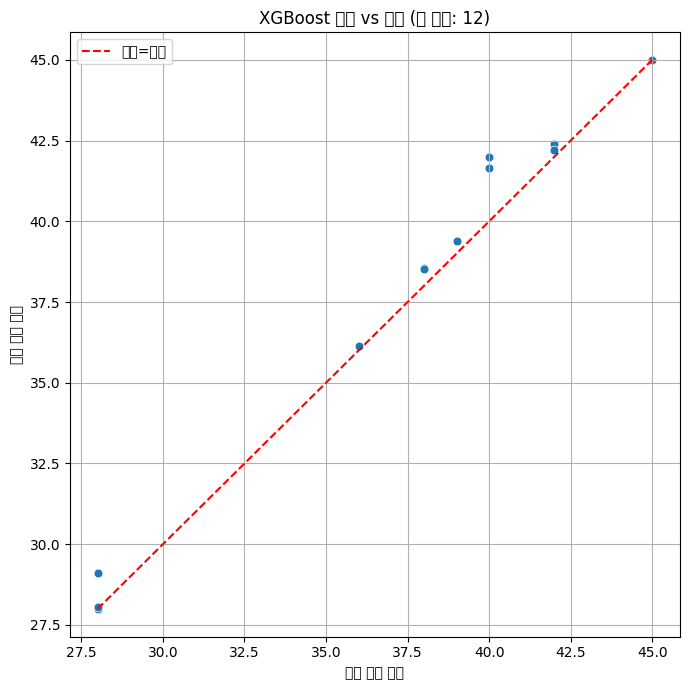

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 예측
y_pred = model.predict(X_test_scaled)

# 시각화용 데이터 정리
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred).reset_index(drop=True)

# 시각화 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 예측 vs 실제 산점도
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test_series, y=y_pred_series, s=40)
plt.plot([y_test_series.min(), y_test_series.max()],
         [y_test_series.min(), y_test_series.max()],
         'r--', label='예측=실제')

plt.xlabel('실제 은퇴 나이')
plt.ylabel('예측 은퇴 나이')
plt.title(f'XGBoost 예측 vs 실제 (점 개수: {len(y_test_series)})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 형식 계산 (AVG, SLG, OBP)
def calculate_missing_metrics(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    df['AVG'] = pd.to_numeric(df['AVG'], errors='coerce')
    df['SLG'] = pd.to_numeric(df['SLG'], errors='coerce')
    df['OBP'] = pd.to_numeric(df['OBP'], errors='coerce')

    df.loc[df['AVG'].isna(), 'AVG'] = df.apply(lambda row: row['H'] / row['AB'] if row['AB'] else np.nan, axis=1)
    df.loc[df['SLG'].isna(), 'SLG'] = df.apply(lambda row: (row['1B'] + 2*row['2B'] + 3*row['3B'] + 4*row['HR']) / row['AB'] if row['AB'] else np.nan, axis=1)
    df.loc[df['OBP'].isna(), 'OBP'] = df.apply(lambda row: (row['H'] + row['BB'] + row['HBP']) / (row['AB'] + row['BB'] + row['HBP']) if (row['AB'] + row['BB'] + row['HBP']) else np.nan, axis=1)

    df.drop(columns='1B', inplace=True)
    return df

# 값 값 차지 표시할 테스트에 목적이 있어도, 지원하는 인덱스 상켜준다.
def print_scores(y_true, y_pred, dataset="TEST"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\ud83d\udcca {dataset} \u2192 MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# 데이터 로드
active_df = pd.read_csv("kbo_hitters_active_enc.csv")
retired_df = pd.read_csv("kbo_hitters_retired_enc.csv")

# 전체 포맷 계산 + 값 복귀
active_df = calculate_missing_metrics(active_df)
retired_df = calculate_missing_metrics(retired_df)

active_df = active_df.groupby("name", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))
retired_df = retired_df.groupby("birth", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))

active_df = active_df.reset_index(drop=True)
retired_df = retired_df.reset_index(drop=True)

# retire_age 계산
retired_df['retire_year'] = retired_df.groupby('birth')['season'].transform('max')
retired_df['retire_age'] = retired_df['retire_year'] - retired_df['birth']

# 필요 피쳐 설정
features_used = ['PA', 'AVG', 'G', 'HR', 'H']
features, targets = [], []

# 은퇴자 feature 생성
for _, group in retired_df.groupby('birth'):
    group = group.sort_values('season')
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    row['team_count'] = group['team'].nunique() if 'team' in group.columns else 1
    features.append(row)
    targets.append(group['retire_age'].iloc[0])

X_all = pd.DataFrame(features)
y_all = np.clip(np.array(targets), 28, 45)

# train/valid/test split
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# 모델 투입
model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# 성능 포스팅
print_scores(y_valid, model.predict(X_valid_scaled), dataset="VALID")
print_scores(y_test, model.predict(X_test_scaled), dataset="TEST")

# 전체 단위로 다시 학습 (active 예측용)
scaler_full = StandardScaler()
X_all_scaled = scaler_full.fit_transform(X_all)
model.fit(X_all_scaled, y_all)

# 현역 선수 예측 feature 생성
predict_data, names = [], []
for name, group in active_df.groupby('name'):
    group = group.sort_values('season')
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = recent['birth'].iloc[0]
    row['last_season'] = recent['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    row['team_count'] = group['team'].nunique() if 'team' in group.columns else 1
    predict_data.append(row)
    names.append(name)

X_active = pd.DataFrame(predict_data)
X_active = X_active.apply(pd.to_numeric, errors='coerce').fillna(X_active.mean(numeric_only=True))
X_active_scaled = scaler_full.transform(X_active)

# 은퇴 예측
predicted_retire_age = model.predict(X_active_scaled)
predicted_retire_age = np.clip(predicted_retire_age, X_active['current_age'], 45)
predicted_retire_year = predicted_retire_age + X_active['birth']

# 결과 저장
result_df = pd.DataFrame({
    'name': names,
    'birth': X_active['birth'],
    '현재_나이': X_active['current_age'],
    '예측_은퇴_나이': np.round(predicted_retire_age, 2),
    '예측_은퇴_연도': np.round(predicted_retire_year).astype(int),
    'last_season': X_active['last_season'],
    '커리어_시즌수': X_active['career_length']
})

result_df.to_csv("active_retire_prediction_machinelearned_final.csv", index=False, encoding="utf-8-sig")
print("\u2705 예측 결과 저장 완료: active_retire_prediction_machinelearned_final.csv")
print(result_df.head(10))


<ipython-input-45-3eaf76bceff0>:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  active_df = active_df.groupby("name", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))
<ipython-input-45-3eaf76bceff0>:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retired_df = retired_df.groupby("birth", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))
ERROR:tornado.application

✅ 예측 결과 저장 완료: active_retire_prediction_machinelearned_final.csv
  name  birth  현재_나이  예측_은퇴_나이  예측_은퇴_연도  last_season  커리어_시즌수
0  강민성   1999     26     27.99      2027         2025        3
1  강민호   1985     40     40.00      2025         2025       22
2  강백호   1999     26     28.42      2027         2025        8
3  강성우   2005     20     28.06      2033         2025        2
4  강승호   1994     31     31.00      2025         2025        9
5  강진성   1993     32     32.00      2025         2025       10
6  강현우   2001     24     28.21      2029         2025        4
7  고명준   2002     23     28.36      2030         2025        4
8  고승민   2000     25     28.40      2028         2025        5
9  고영우   2001     24     28.37      2029         2025        2


In [ ]:
# 성능 측정
def print_scores(y_true, y_pred, dataset="TEST"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {dataset} → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

print_scores(y_valid, model.predict(X_valid_scaled), dataset="VALID")
print_scores(y_test, model.predict(X_test_scaled), dataset="TEST")


📊 VALID → MAE: 0.97, RMSE: 1.22, R²: 0.9261
📊 TEST → MAE: 0.63, RMSE: 0.87, R²: 0.9760


<ipython-input-37-372ef86caae4>:20: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-372ef86caae4>:20: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-372ef86caae4>:20: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-372ef86caae4>:20: UserWarning: Glyph 53748 (\N{HANGUL SYLLABLE TOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-372ef86caae4>:20: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-372ef86caae4>:20: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-372ef86caae4>:20: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-in

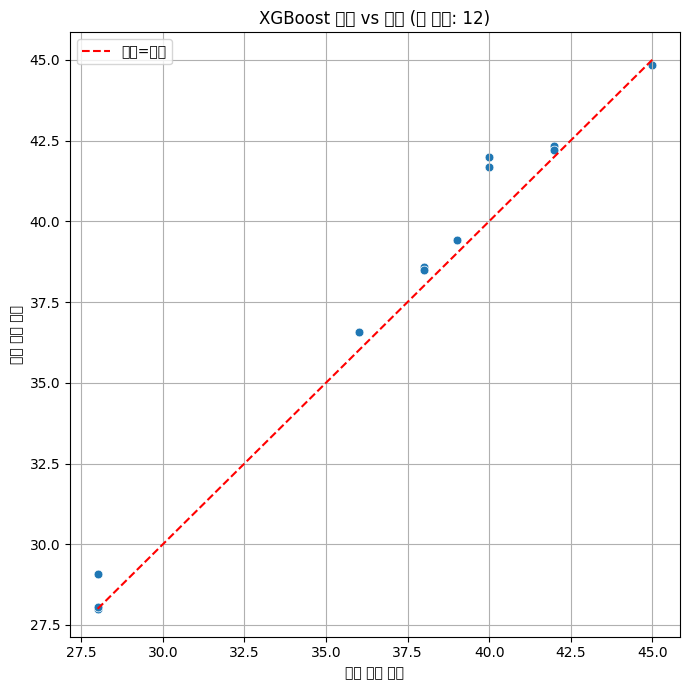

In [ ]:
# 예측 vs 실제 시각화
y_pred_test = model.predict(X_test_scaled)
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred_test).reset_index(drop=True)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test_series, y=y_pred_series, s=40)
plt.plot([y_test_series.min(), y_test_series.max()],
         [y_test_series.min(), y_test_series.max()],
         'r--', label='예측=실제')

plt.xlabel('실제 은퇴 나이')
plt.ylabel('예측 은퇴 나이')
plt.title(f'XGBoost 예측 vs 실제 (점 개수: {len(y_test_series)})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


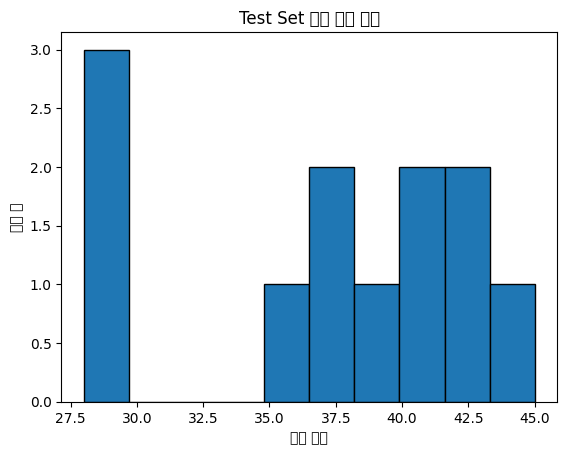

📌 test 샘플 수: 12


In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_test, bins=10, edgecolor='black')
plt.title("Test Set 은퇴 나이 분포")
plt.xlabel("은퇴 나이")
plt.ylabel("선수 수")
plt.show()

print("📌 test 샘플 수:", len(y_test))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 형식 계산 (AVG, SLG, OBP)
def calculate_missing_metrics(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    df['AVG'] = pd.to_numeric(df['AVG'], errors='coerce')
    df['SLG'] = pd.to_numeric(df['SLG'], errors='coerce')
    df['OBP'] = pd.to_numeric(df['OBP'], errors='coerce')

    df.loc[df['AVG'].isna(), 'AVG'] = df.apply(lambda row: row['H'] / row['AB'] if row['AB'] else np.nan, axis=1)
    df.loc[df['SLG'].isna(), 'SLG'] = df.apply(lambda row: (row['1B'] + 2*row['2B'] + 3*row['3B'] + 4*row['HR']) / row['AB'] if row['AB'] else np.nan, axis=1)
    df.loc[df['OBP'].isna(), 'OBP'] = df.apply(lambda row: (row['H'] + row['BB'] + row['HBP']) / (row['AB'] + row['BB'] + row['HBP']) if (row['AB'] + row['BB'] + row['HBP']) else np.nan, axis=1)

    df.drop(columns='1B', inplace=True)
    return df

def print_scores(y_true, y_pred, dataset="TEST"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {dataset} → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# 데이터 로드
active_df = pd.read_csv("kbo_hitters_active_enc.csv")
retired_df = pd.read_csv("kbo_hitters_retired_enc.csv")

active_df = calculate_missing_metrics(active_df)
retired_df = calculate_missing_metrics(retired_df)

active_df = active_df.groupby("name", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))
retired_df = retired_df.groupby("name", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))

active_df = active_df.reset_index(drop=True)
retired_df = retired_df.reset_index(drop=True)

retired_df['retire_year'] = retired_df.groupby('name')['season'].transform('max')
retired_df['retire_age'] = retired_df['retire_year'] - retired_df['birth']

features_used = ['PA', 'AVG', 'G', 'HR', 'H']
features, targets = [], []

for name in retired_df['name'].unique():
    group = retired_df[retired_df['name'] == name].sort_values('season')
    if group.empty:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    row['team_count'] = group['team'].nunique() if 'team' in group.columns else 1
    features.append(row)
    targets.append(group['retire_age'].iloc[0])

X_all = pd.DataFrame(features)
y_all = np.clip(np.array(targets), 28, 45)

X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_scaled, y_train)

print_scores(y_valid, model.predict(X_valid_scaled), dataset="VALID")
print_scores(y_test, model.predict(X_test_scaled), dataset="TEST")

scaler_full = StandardScaler()
X_all_scaled = scaler_full.fit_transform(X_all)
model.fit(X_all_scaled, y_all)

predict_data, names = [], []
for name in active_df['name'].unique():
    group = active_df[active_df['name'] == name].sort_values('season')
    if group.empty:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = recent['birth'].iloc[0]
    row['last_season'] = recent['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    row['team_count'] = group['team'].nunique() if 'team' in group.columns else 1
    predict_data.append(row)
    names.append(name)

X_active = pd.DataFrame(predict_data)
X_active = X_active.apply(pd.to_numeric, errors='coerce').fillna(X_active.mean(numeric_only=True))
X_active_scaled = scaler_full.transform(X_active)

predicted_retire_age = model.predict(X_active_scaled)
predicted_retire_age = np.clip(predicted_retire_age, X_active['current_age'], 45)
predicted_retire_year = predicted_retire_age + X_active['birth']

result_df = pd.DataFrame({
    'name': names,
    'birth': X_active['birth'],
    '현재_나이': X_active['current_age'],
    '예측_은퇴_나이': np.round(predicted_retire_age, 2),
    '예측_은퇴_연도': np.round(predicted_retire_year).astype(int),
    'last_season': X_active['last_season'],
    '커리어_시즌수': X_active['career_length']
})

result_df.to_csv("re_1.csv", index=False, encoding="utf-8-sig")
print("✅ 예측 결과 저장 완료: re_1.csv")
print(result_df.head(10))


<ipython-input-1-ed00b64d522f>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  active_df = active_df.groupby("name", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))
<ipython-input-1-ed00b64d522f>:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retired_df = retired_df.groupby("name", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))


📊 VALID → MAE: 0.15, RMSE: 0.28, R²: 0.9952
📊 TEST → MAE: 0.14, RMSE: 0.27, R²: 0.9952
✅ 예측 결과 저장 완료: re_1.csv
  name  birth  현재_나이  예측_은퇴_나이  예측_은퇴_연도  last_season  커리어_시즌수
0  천성호   1997     28     28.00      2025         2025        4
1  강현우   2001     24     27.96      2029         2025        4
2  윤준혁   2001     24     27.99      2029         2025        2
3  함창건   2001     24     27.99      2029         2025        2
4  손호영   1994     31     31.00      2025         2025        6
5  이주형   2001     24     28.57      2030         2025        4
6  박지훈   2000     25     28.00      2028         2025        4
7  오명진   2001     24     28.00      2029         2025        4
8  박주홍   2001     24     28.00      2029         2025        6
9  김지찬   2001     24     28.04      2029         2025        6


In [ ]:
import sys

# 노트북이 코랩에서 실행 중인지 체크합니다.
if 'google.colab' in sys.modules:
  !echo 'debconf debconf/f rontend select Noninteractive' | debconf-set-selections
  # 나눔 폰트를 설치합니다.
  !sudo apt-get -qq -y install fonts-nanum
  import matplotlib.font_manager as fm
  font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
  for fpath in font_files:
    fm. fontManager.addfont(fpath)
  # 나눔바른고딕 폰트로 설정합니다.
  import matplotlib.pyplot as plt
  plt.rc('font', family= 'NanumBarunGothic')
  # 마이너스 기호 표시 오류 수정
  import matplotlib
  matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


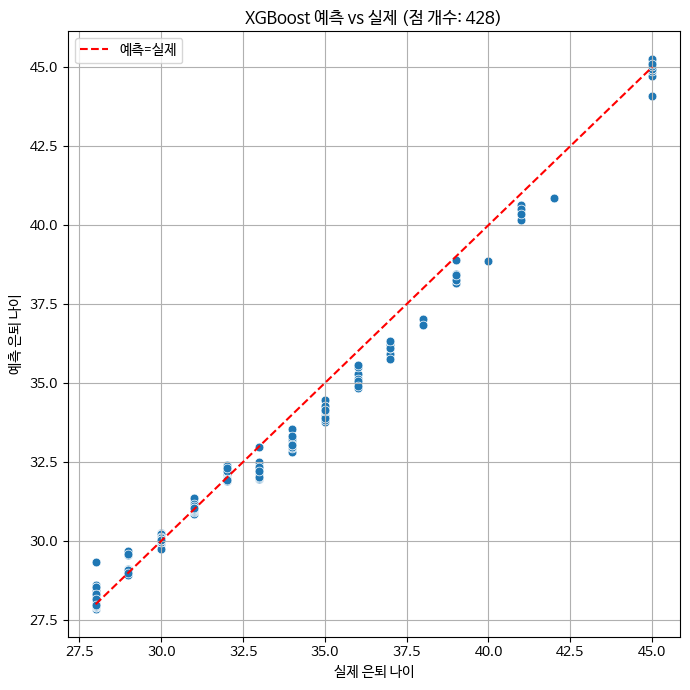

In [ ]:
# 예측 vs 실제 시각화
y_pred_test = model.predict(X_test_scaled)
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred_test).reset_index(drop=True)

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test_series, y=y_pred_series, s=40)
plt.plot([y_test_series.min(), y_test_series.max()],
         [y_test_series.min(), y_test_series.max()],
         'r--', label='예측=실제')

plt.xlabel('실제 은퇴 나이')
plt.ylabel('예측 은퇴 나이')
plt.title(f'XGBoost 예측 vs 실제 (점 개수: {len(y_test_series)})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


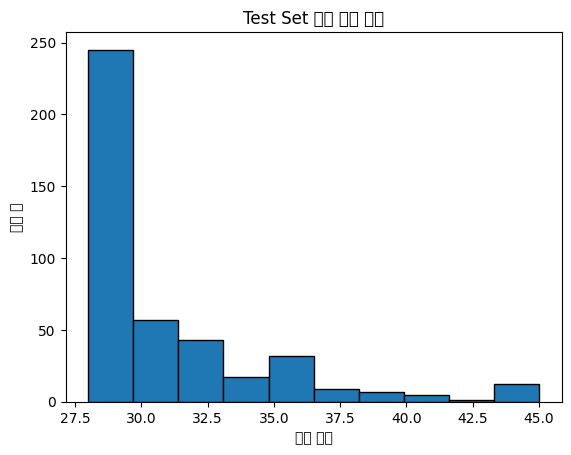

📌 test 샘플 수: 428


In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_test, bins=10, edgecolor='black')
plt.title("Test Set 은퇴 나이 분포")
plt.xlabel("은퇴 나이")
plt.ylabel("선수 수")
plt.show()

print("📌 test 샘플 수:", len(y_test))


In [ ]:
print("📊 y_all 범위:", y_all.min(), "~", y_all.max())
print("📊 test set 샘플 수:", len(y_test))
print("📊 train/test 중복 선수 수:", len(set(X_train['birth']) & set(X_test['birth'])))


📊 y_all 범위: 28 ~ 45
📊 test set 샘플 수: 428
📊 train/test 중복 선수 수: 54


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 형식 계산 (AVG, SLG, OBP)
def calculate_missing_metrics(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    df['AVG'] = pd.to_numeric(df['AVG'], errors='coerce')
    df['SLG'] = pd.to_numeric(df['SLG'], errors='coerce')
    df['OBP'] = pd.to_numeric(df['OBP'], errors='coerce')

    df.loc[df['AVG'].isna(), 'AVG'] = df.apply(lambda row: row['H'] / row['AB'] if row['AB'] else np.nan, axis=1)
    df.loc[df['SLG'].isna(), 'SLG'] = df.apply(lambda row: (row['1B'] + 2*row['2B'] + 3*row['3B'] + 4*row['HR']) / row['AB'] if row['AB'] else np.nan, axis=1)
    df.loc[df['OBP'].isna(), 'OBP'] = df.apply(lambda row: (row['H'] + row['BB'] + row['HBP']) / (row['AB'] + row['BB'] + row['HBP']) if (row['AB'] + row['BB'] + row['HBP']) else np.nan, axis=1)

    df.drop(columns='1B', inplace=True)
    return df

def print_scores(y_true, y_pred, dataset="TEST"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {dataset} → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# 데이터 로드
active_df = pd.read_csv("kbo_hitters_active_enc.csv")
retired_df = pd.read_csv("kbo_hitters_retired_enc.csv")

active_df = calculate_missing_metrics(active_df)
retired_df = calculate_missing_metrics(retired_df)

active_df = active_df.groupby("name", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))
retired_df = retired_df.groupby("name", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))

active_df = active_df.reset_index(drop=True)
retired_df = retired_df.reset_index(drop=True)

retired_df['retire_year'] = retired_df.groupby('name')['season'].transform('max')
retired_df['retire_age'] = retired_df['retire_year'] - retired_df['birth']

features_used = ['PA', 'AVG', 'G', 'HR', 'H']
features, targets, groups = [], [], []

for name in retired_df['name'].unique():
    group = retired_df[retired_df['name'] == name].sort_values('season')
    if group.empty:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = group['birth'].iloc[0]
    row['last_season'] = group['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    row['team_count'] = group['team'].nunique() if 'team' in group.columns else 1
    features.append(row)
    targets.append(group['retire_age'].iloc[0])
    groups.append(name)

X_all = pd.DataFrame(features)
y_all = np.clip(np.array(targets), 28, 45)

# Group-wise split to avoid data leakage
splitter = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(splitter.split(X_all, y_all, groups=groups))
X_train, X_temp = X_all.iloc[train_idx], X_all.iloc[temp_idx]
y_train, y_temp = y_all[train_idx], y_all[temp_idx]

valid_split = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
valid_idx, test_idx = next(valid_split.split(X_temp, y_temp, groups=np.array(groups)[temp_idx]))
X_valid, X_test = X_temp.iloc[valid_idx], X_temp.iloc[test_idx]
y_valid, y_test = y_temp[valid_idx], y_temp[test_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_scaled, y_train)

print_scores(y_valid, model.predict(X_valid_scaled), dataset="VALID")
print_scores(y_test, model.predict(X_test_scaled), dataset="TEST")

scaler_full = StandardScaler()
X_all_scaled = scaler_full.fit_transform(X_all)
model.fit(X_all_scaled, y_all)

predict_data, names = [], []
for name in active_df['name'].unique():
    group = active_df[active_df['name'] == name].sort_values('season')
    if group.empty:
        continue
    recent = group.tail(9)
    row = {}
    for col in features_used:
        values = pd.to_numeric(recent[col], errors='coerce').values
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_trend'] = (values[-1] - values[0]) / abs(values[0]) if len(values) > 1 and values[0] != 0 else 0.0
    row['birth'] = recent['birth'].iloc[0]
    row['last_season'] = recent['season'].max()
    row['career_length'] = len(group)
    row['current_age'] = row['last_season'] - row['birth']
    row['team_count'] = group['team'].nunique() if 'team' in group.columns else 1
    predict_data.append(row)
    names.append(name)

X_active = pd.DataFrame(predict_data)
X_active = X_active.apply(pd.to_numeric, errors='coerce').fillna(X_active.mean(numeric_only=True))
X_active_scaled = scaler_full.transform(X_active)

predicted_retire_age = model.predict(X_active_scaled)
predicted_retire_age = np.clip(predicted_retire_age, X_active['current_age'], 45)
predicted_retire_year = predicted_retire_age + X_active['birth']

result_df = pd.DataFrame({
    'name': names,
    'birth': X_active['birth'],
    '현재_나이': X_active['current_age'],
    '예측_은퇴_나이': np.round(predicted_retire_age, 2),
    '예측_은퇴_연도': np.round(predicted_retire_year).astype(int),
    'last_season': X_active['last_season'],
    '커리어_시즌수': X_active['career_length']
})

result_df.to_csv("re_2.csv", index=False, encoding="utf-8-sig")
print("✅ 예측 결과 저장 완료: re_2.csv")
print(result_df.head(10))

<ipython-input-43-61bac9c8aa17>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  active_df = active_df.groupby("name", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))
<ipython-input-43-61bac9c8aa17>:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retired_df = retired_df.groupby("name", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))


📊 VALID → MAE: 0.13, RMSE: 0.26, R²: 0.9957
📊 TEST → MAE: 0.17, RMSE: 0.34, R²: 0.9932
✅ 예측 결과 저장 완료: re_2.csv
  name  birth  현재_나이  예측_은퇴_나이  예측_은퇴_연도  last_season  커리어_시즌수
0  천성호   1997     28     28.00      2025         2025        4
1  강현우   2001     24     27.96      2029         2025        4
2  윤준혁   2001     24     27.99      2029         2025        2
3  함창건   2001     24     27.99      2029         2025        2
4  손호영   1994     31     31.00      2025         2025        6
5  이주형   2001     24     28.57      2030         2025        4
6  박지훈   2000     25     28.00      2028         2025        4
7  오명진   2001     24     28.00      2029         2025        4
8  박주홍   2001     24     28.00      2029         2025        6
9  김지찬   2001     24     28.04      2029         2025        6
